In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from time import time
from PINN.VanillaOptions import VanillaOptionPINN
from PINN.utilities import V_BS, V_BS_CN, european_option_greeks

import warnings
warnings.filterwarnings("ignore")

## European Put Option

In [42]:
# parameters
K = 4
sigma = 0.3
r = 0.03
T = 1
S_inf = 3 * K
N_pde = 2500

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# load data
ib = torch.load('data/european_put_ib_sobol.pt')
S_ib, tau_ib, V_ib = ib['S'], ib['tau'], ib['V']

# load results
results = np.load('data/output/results.npy', allow_pickle=True).item()
RMSE = results['RMSE']
max_pointwise_error = results['max_pointwise_error']
SEEDS = results['SEEDS']

RMSE_mean = RMSE.mean()
RMSE_std = RMSE.std()
mpe_mean = max_pointwise_error.mean()
mpe_std = max_pointwise_error.std()
best_idx = np.argmin(RMSE)

model_name = f'european_put_{best_idx}'
model = torch.load(f'models/european_put/{model_name}.pt', map_location=device)

Device: cpu


VanillaOptionPINN(
  (V_nn): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)
Number of parameters: 501


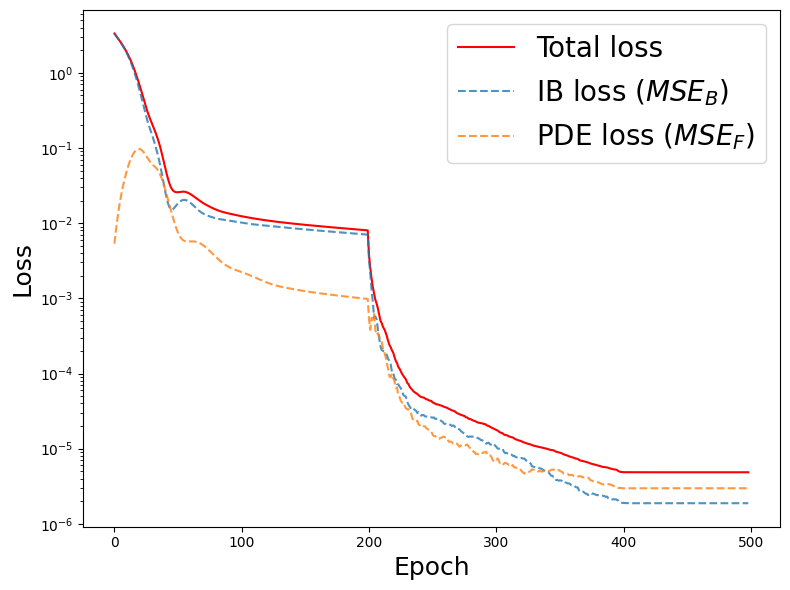

Final loss: 4.85567613850435e-06


In [31]:
TRAIN = False
# model_name = 'european'

if TRAIN:
    nn = torch.nn.Sequential(
            torch.nn.Linear(2, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 1)
    )
    model = VanillaOptionPINN(nn, K, T, r, sigma, S_inf,
                              type='put', style='european',
                              device=device).to(device)
    loss_weights = (1., 1., 1.)

    training_time = time()
    # First train with Adam
    model.fit(tau_ib, S_ib, V_ib,
              tau_pde=None, S_pde=None,
              valid=False,
              N_pde=N_pde, sampling='sobol', resample=0,
              loss_weights=loss_weights,
              epochs=200, optimizer='adam', lr=0.005)
    # Then train with L-BFGS
    model.fit(tau_ib, S_ib, V_ib,
              tau_pde=None, S_pde=None,
              valid=False,
              N_pde=N_pde, sampling='sobol', resample=0,
              loss_weights=loss_weights,
              epochs=300, optimizer='lbfgs', line_search_fn='strong_wolfe')
    training_time = time() - training_time
    print('Training time:', training_time)
    # save model
    torch.save(model, f'models/{model_name}.pt')

model = torch.load(f'models/european_put/{model_name}.pt', map_location=device)
print(model)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))
model.plot_history(save=True, title='', figsize=(8, 6), fontsize=18, file_name=f'data/images/loss_{model_name}.pdf')
print('Final loss:', model.loss_history['total'][-1])

### Error Analysis and Comparison to Crank Nicolson

MSE: 9.144343877946212e-08
RMSE: 0.00030239616197872305
-0.007652163505554199 0.02835845947265625


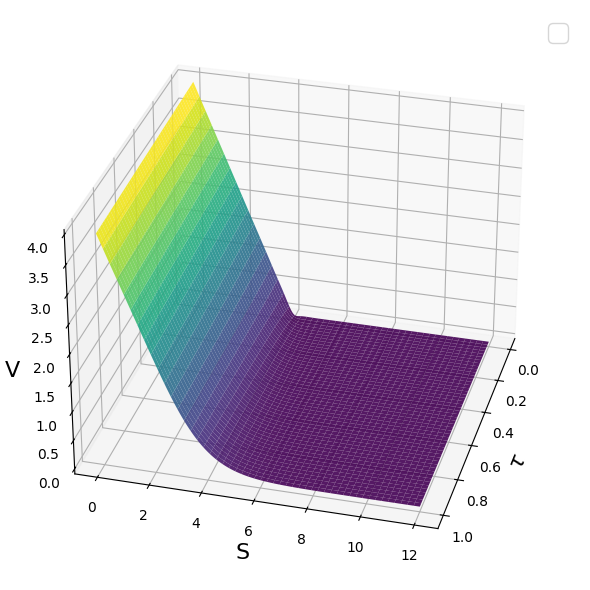

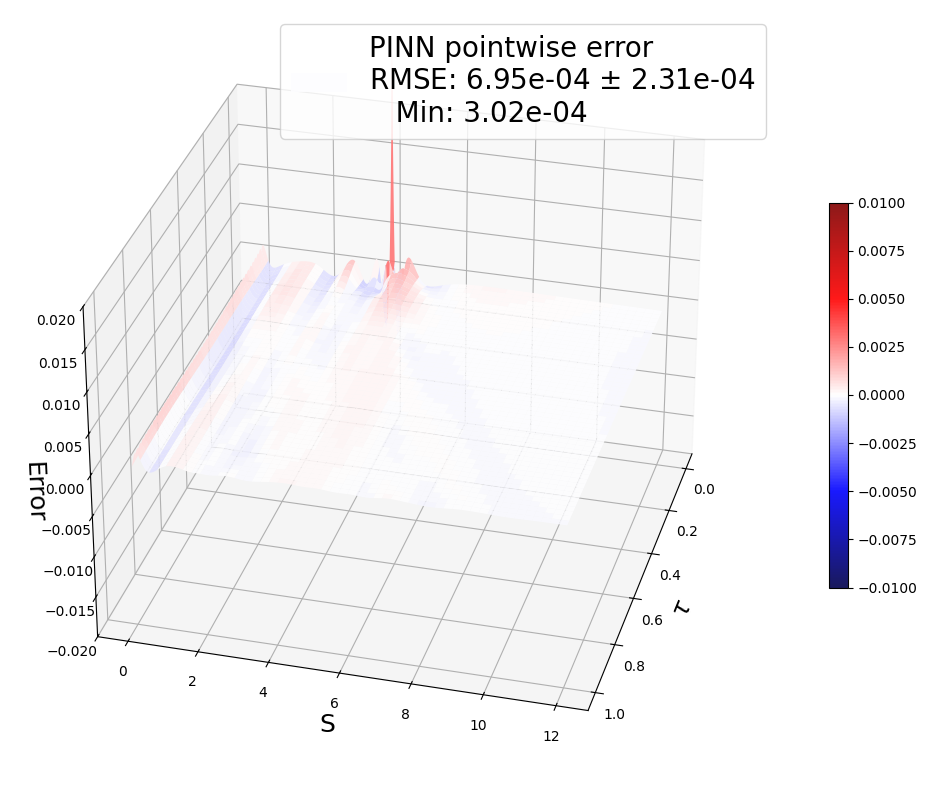

In [56]:
SAVE_FIG = True
model_name = f'european_put_{best_idx}'
model = torch.load(f'models/european_put/{model_name}.pt', map_location=device)

S_eval = torch.linspace(0, S_inf, 1000)
tau_eval = torch.linspace(0, T, 1000)
# S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval)  # torch meshgrid uses different indexing
S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval, indexing='xy')
V_pred = model(tau_eval.reshape(-1, 1), S_eval.reshape(-1, 1)).detach().numpy().reshape(1000, 1000)#.T

# compute error metrics
# Using np.meshgrid, torch.meshgrid uses different indexing
S_eval = np.linspace(0, S_inf, 1000)
tau_eval = np.linspace(0, T, 1000)
S_eval, tau_eval = np.meshgrid(S_eval, tau_eval)
V_true = V_BS(tau_eval, S_eval, K, r, sigma, 'put')
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(S_eval, tau_eval, V_true, cmap='viridis')
V_err = V_pred - V_true
mse = np.mean(V_err**2)
rmse = np.sqrt(mse)
print('MSE:', mse)
print('RMSE:', rmse)
print(V_err.min(), V_err.max())

# 3d plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_pred,
                       cmap='viridis', alpha=0.9)
ax.set_xlabel(r'$\tau$', fontsize=16)
ax.set_ylabel('S', fontsize=16)
ax.set_zlabel('V', fontsize=16)
plt.legend(fontsize=18)
ax.view_init(elev=30, azim=15)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig('./data/images/sol_european_3d.pdf', bbox_inches='tight')
plt.show()

# plot error surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_err,
                       label=f'PINN pointwise error\nRMSE: {RMSE_mean:.2e} $\pm$ {RMSE_std:.2e}\n   Min: {rmse:.2e}',
                       cmap='seismic', vmin=-0.01, vmax=0.01, alpha=0.9)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_zlim(-0.02, 0.02)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('S', fontsize=18)
ax.set_zlabel('Error', fontsize=18)
plt.legend(fontsize=20, loc='upper right')
ax.view_init(elev=30, azim=15)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig('./data/images/sol_european_3d_err.pdf', bbox_inches='tight')
plt.show()

MSE: 8.531793395780545e-08
RMSE: 0.00029209233806761425
-0.0010429283759545438 0.026666666666666693


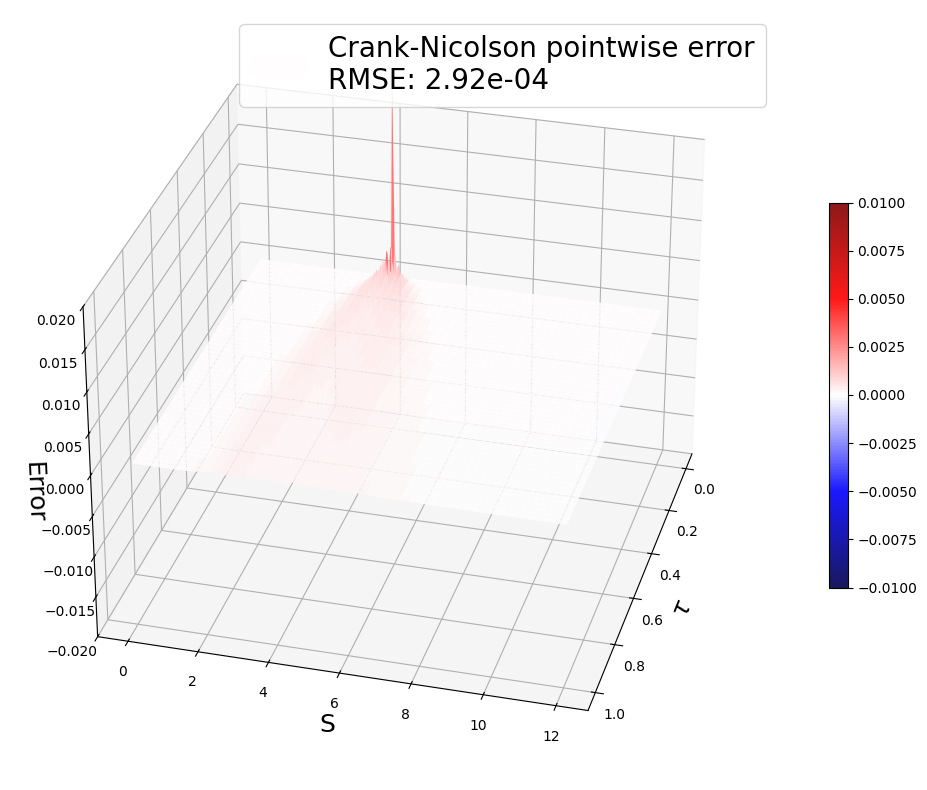

In [47]:
from scipy.interpolate import RegularGridInterpolator

SAVE_FIG = True

# Crank-Nicolson solution
V_CN, S_CN, t_CN = V_BS_CN(100, 100, K, T, r, sigma, S_inf=K*3, type='put', style='european')
V_CN = V_CN.T

# interpolate CN solution on eval grid
interpolator = RegularGridInterpolator((S_CN, t_CN), V_CN, method='linear', bounds_error=False, fill_value=np.nan)
S_eval = np.linspace(0, S_inf, 1000)
tau_eval = np.linspace(0, T, 1000)
S_eval, tau_eval = np.meshgrid(S_eval, tau_eval)
V_pred_CN = interpolator((S_eval, tau_eval))

# compute error metrics
V_true = V_BS(tau_eval, S_eval, K, r, sigma)
V_err_CN = V_pred_CN - V_true
MSE_CN = np.mean(V_err_CN**2)
RMSE_CN = np.sqrt(MSE_CN)
print('MSE:', MSE_CN)
print('RMSE:', RMSE_CN)
print(V_err_CN.min(), V_err_CN.max())


# # 3d plot CN solution
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(S_eval, tau_eval, V_pred_CN, cmap='viridis')
# ax.set_xlabel('S', fontsize=14)
# ax.set_ylabel('tau', fontsize=14)
# ax.set_zlabel('V', fontsize=14)
# ax.set_title('Crank-Nicolson Solution', fontsize=16)
# plt.show()


# plot error surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_err_CN, label=f'Crank-Nicolson pointwise error\nRMSE: {RMSE_CN:.2e}', cmap='seismic', vmin=-0.01, vmax=0.01, alpha=0.9)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_zlim(-0.02, 0.02)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('S', fontsize=18)
ax.set_zlabel('Error', fontsize=18)
plt.legend(fontsize=20, loc='upper right')
ax.view_init(elev=30, azim=15)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig('./data/images/sol_european_cn_err.pdf', bbox_inches='tight')
plt.show()

### Greeks

MSE: 5.903255165258154e-06
RMSE: 0.0024296615330654915
-0.5282405018806458 0.4137541651725769


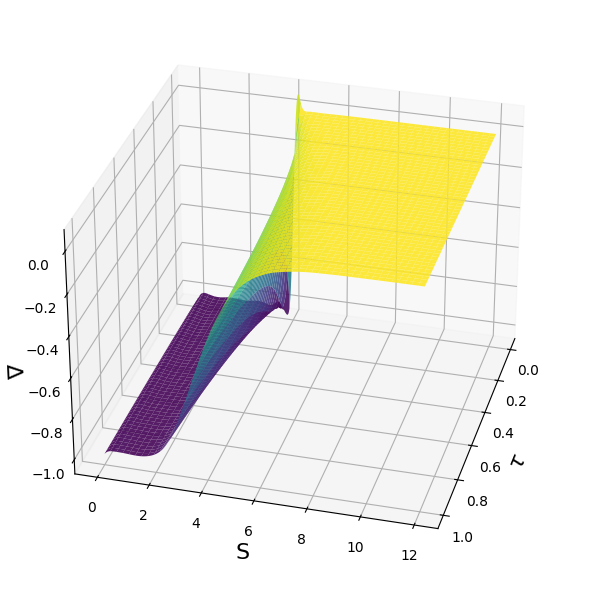

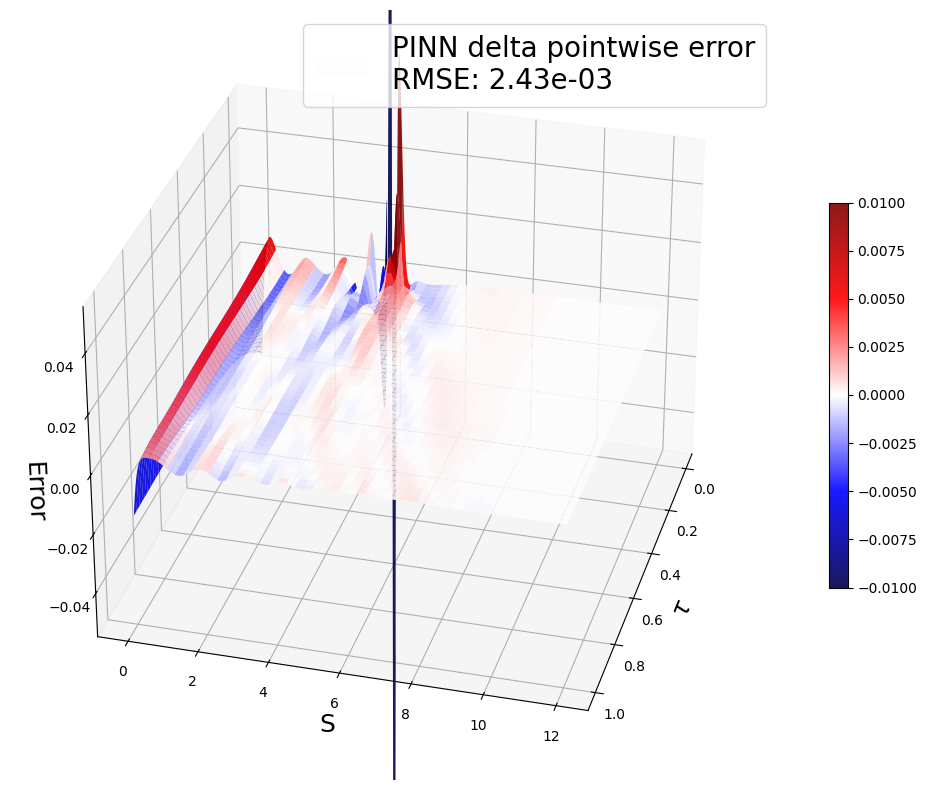

In [ ]:
from scipy.stats import norm

SAVE_FIG = True
model_name = 'european_put_2mlp20'
model = torch.load(f'models/{model_name}.pt', map_location=device)

S_eval = torch.linspace(0, S_inf, 1000)
tau_eval = torch.linspace(0, T, 1000)
S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval, indexing='xy')
S_eval.requires_grad = True
tau_eval.requires_grad = True
delta = model.evaluate_greeks(tau_eval.reshape(-1, 1), S_eval.reshape(-1, 1), 'delta').reshape(1000, 1000).detach().numpy()

S_eval = np.linspace(0, S_inf, 1000)
tau_eval = np.linspace(0, T, 1000)
S_eval, tau_eval = np.meshgrid(S_eval, tau_eval)
delta_true = -norm.cdf(-d1)
delta_err = delta - delta_true
MSE_delta = np.mean(delta_err**2)
RMSE_delta = np.sqrt(MSE_delta)
print('MSE:', MSE_delta)
print('RMSE:', RMSE_delta)
print(delta_err.min(), delta_err.max())

# plot delta surface
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, delta, cmap='viridis', alpha=0.9)
ax.set_xlabel(r'$\tau$', fontsize=16)
ax.set_ylabel('S', fontsize=16)
ax.set_zlabel(r'$\Delta$', fontsize=16)
ax.view_init(elev=30, azim=15)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig('./data/images/delta_european.pdf', bbox_inches='tight')
plt.show()

# plot delta error surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, delta_err, label=f'PINN delta pointwise error\nRMSE: {RMSE_delta:.2e}', cmap='seismic', vmin=-0.01, vmax=0.01, alpha=0.9)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_zlim(-0.055, 0.055)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('S', fontsize=18)
ax.set_zlabel('Error', fontsize=18)
plt.legend(fontsize=20, loc='upper right')
ax.view_init(elev=30, azim=15)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig('./data/images/delta_european_err.pdf', bbox_inches='tight')
plt.show()

## American Call Option

Recovering European call

In [ ]:
# parameters
K = 4
sigma = 0.3
r = 0.03
T = 1
S_inf = 3 * K
N_pde = 2500

# load data
ib = torch.load('data/european_call_ib_sobol.pt')
S_ib, tau_ib, V_ib = ib['S'], ib['tau'], ib['V']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


No collocation points provided
Sampling 5000 collocation points (sobol)
Optimizer: adam
Device: cpu
Epoch 100/300    |    Loss: 0.05440779495984316
Epoch 200/300    |    Loss: 0.007405072450637817
Epoch 300/300    |    Loss: 0.004589937161654234
No collocation points provided
Sampling 5000 collocation points (sobol)
Optimizer: lbfgs
Device: cpu
Epoch 100/400    |    Loss: 0.000155225792696001
Epoch 200/400    |    Loss: 0.00011382860611774959
Epoch 300/400    |    Loss: 0.00011382860611774959
Epoch 400/400    |    Loss: 0.00011382860611774959
Training time: 64.27981901168823
VanillaOptionPINN(
  (V_nn): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)
Number of parameters: 921


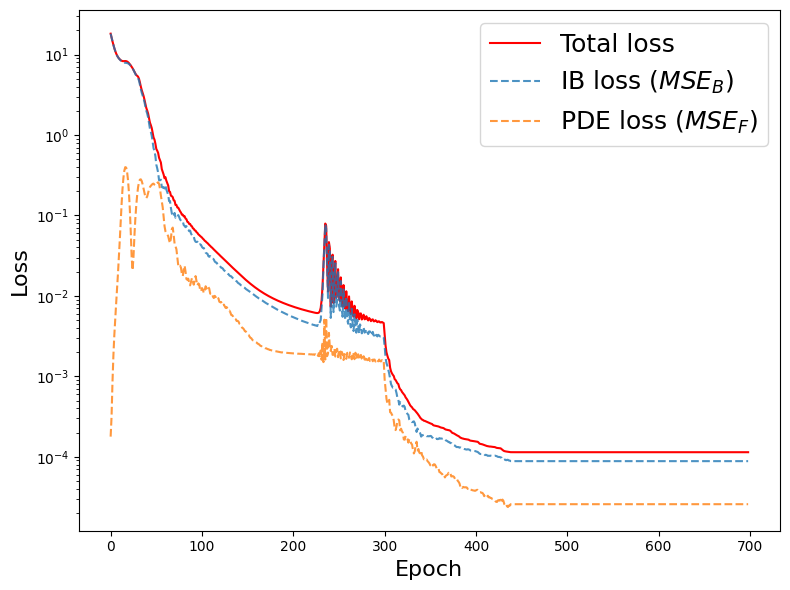

Final loss: 0.00011382860611774959


In [25]:
TRAIN = True
model_name = 'european_call'

if TRAIN:
    nn = torch.nn.Sequential(
            torch.nn.Linear(2, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 1)
    )
    model = VanillaOptionPINN(nn, K, T, r, sigma, S_inf,
                              type='call', style='european',
                              device=device).to(device)
    loss_weights = (1., 1., 1.)

    training_time = time()
    # First train with Adam
    model.fit(tau_ib, S_ib, V_ib,
              tau_pde=None, S_pde=None,
              valid=False,
              N_pde=N_pde, sampling='sobol', resample=0,
              loss_weights=loss_weights,
              epochs=300, optimizer='adam', lr=0.01)
    # Then train with L-BFGS
    model.fit(tau_ib, S_ib, V_ib,
              tau_pde=None, S_pde=None,
              valid=False,
              N_pde=N_pde, sampling='sobol', resample=0,
              loss_weights=loss_weights,
              epochs=400, optimizer='lbfgs', line_search_fn='strong_wolfe')
    training_time = time() - training_time
    print('Training time:', training_time)
    # save model
    torch.save(model, f'models/{model_name}.pt')

model = torch.load(f'models/{model_name}.pt', map_location=device)
print(model)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))
model.plot_history(save=False, title='', figsize=(8, 6), fontsize=16, file_name=f'data/images/loss_{model_name}.pdf')
print('Final loss:', model.loss_history['total'][-1])

MSE: 3.4549859882230047e-06
RMSE: 0.0018587592604269669
-0.021149039268493652 0.07091724872589111


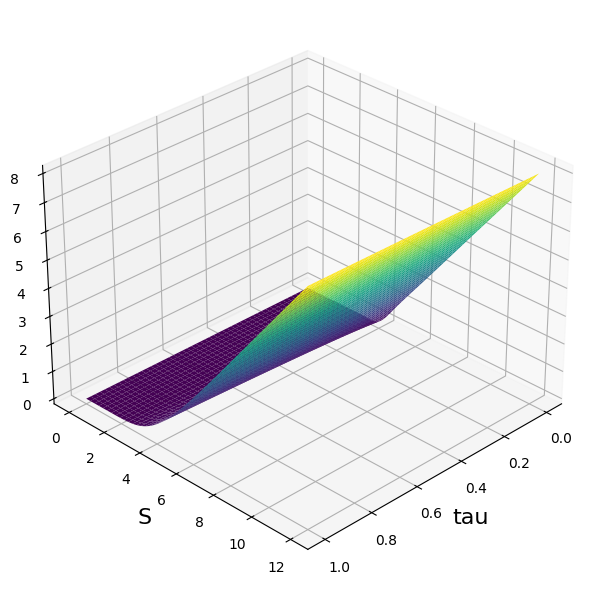

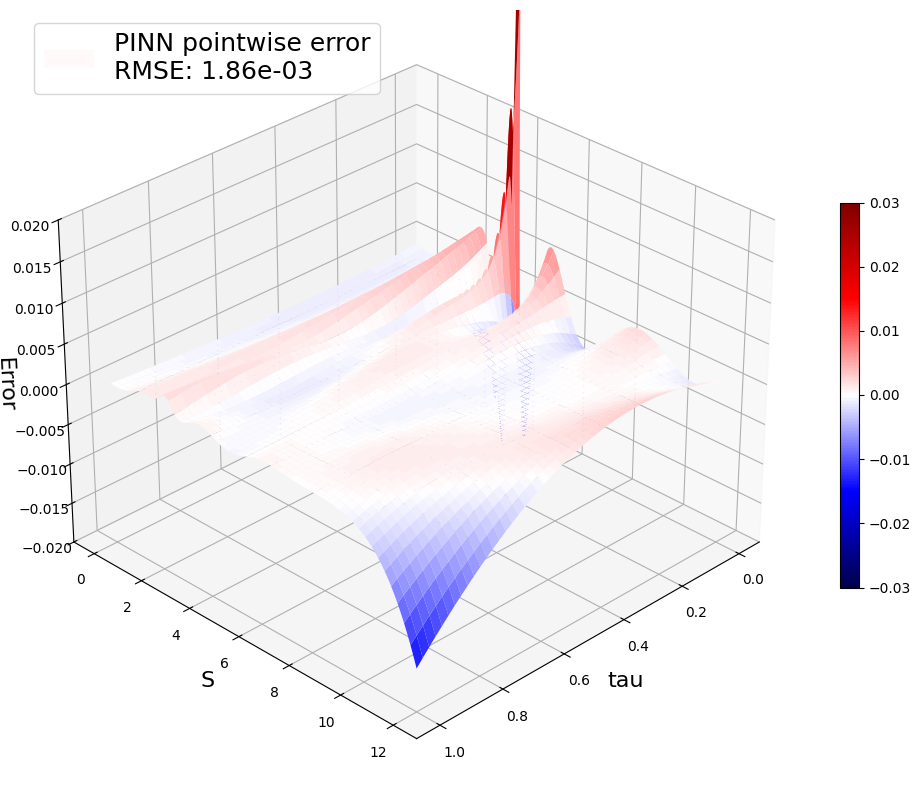

In [26]:
SAVE_FIG = False
# model_name = 'european_put_2mlp20'
# model = torch.load(f'models/{model_name}.pt', map_location=device)

S_eval = torch.linspace(0, S_inf, 1000)
tau_eval = torch.linspace(0, T, 1000)
# S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval)  # torch meshgrid uses different indexing
S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval, indexing='xy')
V_pred = model(tau_eval.reshape(-1, 1), S_eval.reshape(-1, 1)).detach().numpy().reshape(1000, 1000)#.T

# compute error metrics
# Using np.meshgrid, torch.meshgrid uses different indexing
S_eval = np.linspace(0, S_inf, 1000)
tau_eval = np.linspace(0, T, 1000)
S_eval, tau_eval = np.meshgrid(S_eval, tau_eval)
V_true = V_BS(tau_eval, S_eval, K, r, sigma, 'call')
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(S_eval, tau_eval, V_true, cmap='viridis')
V_err = V_pred - V_true
MSE = np.mean(V_err**2)
RMSE = np.sqrt(MSE)
print('MSE:', MSE)
print('RMSE:', RMSE)
print(V_err.min(), V_err.max())

# 3d plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_pred, cmap='viridis')
ax.set_xlabel('tau', fontsize=16)
ax.set_ylabel('S', fontsize=16)
# ax.set_zlabel('V', fontsize=14)
ax.view_init(elev=30, azim=45)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig('./data/images/sol_american_call_3d.pdf', bbox_inches='tight')
plt.show()

# plot error surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_err, label=f'PINN pointwise error\nRMSE: {RMSE:.2e}', cmap='seismic', vmin=-0.03, vmax=0.03)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_zlim(-0.02, 0.02)
ax.set_xlabel('tau', fontsize=16)
ax.set_ylabel('S', fontsize=16)
ax.set_zlabel('Error', fontsize=16)
plt.legend(fontsize=18)
ax.view_init(elev=30, azim=45)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig('./data/images/sol_american_call_3d_err.pdf', bbox_inches='tight')
plt.show()